<a href="https://colab.research.google.com/github/Yoon0527/AI_study/blob/main/Hands_on_ML(3~4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3장. 분류

In [ ]:
# sklearn에서 제공하는 mnist dataset load
# as_frame: pandas로 더 쉽게 만들어줌(https://data-newbie.tistory.com/519)
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
# feature값 조회
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
# X, y 각각 mnist['data']와 mnist['target'] 데이터를 저장
X, y = mnist["data"], mnist["target"]

# X의 형상 확인
X.shape

(70000, 784)

In [ ]:
# y의 형상 확인
y.shape

(70000,)

이미지가 70000개 있고 각 이미지에는 784개의 특성이 있다(28x28).

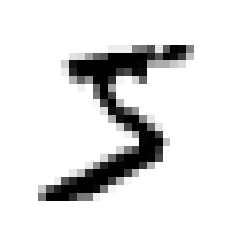

In [ ]:
# %matplotlib inline: 해당 노트북에 이미지 등을 바로 출력한다.
%matplotlib inline

# matplotlib과 matplotlib.pyplot의 차이점(https://kongdols-room.tistory.com/72)
  # matplotlib: 전체를 아우르는 패키지
  # matplotlib.pyplot: 사용환경 인터페이스(state-machine interface)를 제공하고, 겉으로는 드러나지 않으면서 자동으로 figure와 axes를 생성하며, 정의된 플롯을 얻을 수 있도록 만들어준다.
    # figure: matplotlib은 한 번에 한장의 그림을 그린다. 이 그림이 figure. 그림을 그리는 캔버스이고, 하나의 figure에는 여러 개의 plot이 들어갈 수 있다.
    # axes: 보통 plot으로 생각하는 하나의 그래프. 각각의 axes는 개별적으로 제목 및 x/y 레이블을 가질 수 있다.
import matplotlib as mpl
import matplotlib.pyplot as plt

# X에 저장된 mnist['data']의 첫번째 데이터(벡터)를 some_digit에 저장
some_digit = X[0]

# some_digit에 저장한 벡터값을 28x28 배열 형태로 재구성
some_digit_image = some_digit.reshape(28, 28)

# 이미지 출력
# cmap(색 지정) = mpl.cm.binary(binary 색 지정)
  # 색 참고: https://codetorial.net/matplotlib/set_colormap.html
plt.imshow(some_digit_image, cmap=mpl.cm.binary)

# 축은 출력하지 않음
plt.axis("off")

plt.show()

In [ ]:
# 위의 출력한 손글씨의 정답을 출력
y[0]

'5'

In [ ]:
# 레이블은 문자열임. 대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환
import numpy as np
y = y.astype(np.uint8)

In [ ]:
def plot_digit(data):
    # 이미지 벡터를 28x28 배열로 reshape
    image = data.reshape(28, 28)

    # 이미지 출력
    # interpolation: 보간법을 말한다. 영상을 기하학적 변환할 때, 원 영상의 아무런 정보를 받지 못하는 Pixel(이런 Pixel을 hole이라고 함)이 생길 수 있는데,
      # interpolation이란 위와 같은 픽셀 주변의 알고 있는 값들을 이용해 pixel의 값을 유도하는 과정을 뜻한다.
      # neareast: 최근접 보간법으로 가장 가까운 화소값을 사용한다. 따라서 계산이 빠르지만 경계선이 망가지고 해상도가 낮아진다.
      # interpolation 종류 참고: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=dic1224&logNo=220840978075
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

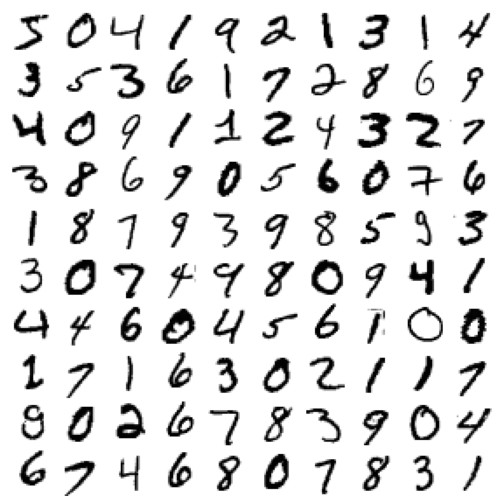

In [ ]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [ ]:
# 데이터를 60000개와 10000개로 나누어 저장
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 이진 분류기 훈련

In [ ]:
# 5는 True, 나머지 숫자는 모두 False로 처리하는 이진 분류
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
# sklearn에서 제공하는 확률적 경사 하강법 분류기(SGDClassfier) import
from sklearn.linear_model import SGDClassifier

# SGDClassifier 객체 생성
  # max_iter: 반복 횟수
  # tol: 정밀도
  # random_state: 난수 초기값
  # 다른 옵션 참고: https://inuplace.tistory.com/516
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
# some_digit에 저장된 X[0]의 이미지를 SGDClassifier로 감지
sgd_clf.predict([some_digit])

array([ True])

### 성능 측정

#### 교차 검증을 사용한 정확도 측정

In [ ]:
# StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계측적 샘플링을 수행하는 방식
  # 매 반복에서 분류기 객체를 복제해 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만든다. 
  # 그런 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력한다.
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# skfolds.split()을 호출해서 폴드별 X_train, y_train_5의 로우 인덱스를 array로 변환
for train_index, test_index in skfolds.split(X_train, y_train_5):

    # 클론 객체 생성
    clone_clf = clone(sgd_clf)

    # train_index에 저장된 인덱스에 해당하는 X_train의 데이터를 저장
    X_train_folds = X_train[train_index]

    # train_index에 저장된 인덱스에 해당하는 y_train_5의 데이터를 저장
    y_train_folds = y_train_5[train_index]

    # test_index에 저장된 인덱스에 해당하는 X_train의 데이터를 저장
    X_test_fold = X_train[test_index]

    # test_index에 저장된 인덱스에 해당하는 y_train_5의 데이터를 저장
    y_test_fold = y_train_5[test_index]

    # 매 반복마다 분류기 객체를 복제해서 훈련 폴드로 훈련
    clone_clf.fit(X_train_folds, y_train_folds)

    # 테스트 폴드로 예측을 만든다.
    y_pred = clone_clf.predict(X_test_fold)

    # 올바른 예측의 수를 세어서 정확한 예측의 비율을 출력
    # https://velog.io/@ntbij29/chapter-3-%EB%B6%84%EB%A5%98-3.3
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기 만들기
from sklearn.base import BaseEstimator

# 위 코드에서 import 한 BaseEstimator 상속
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

#### 오차 행렬

In [ ]:
# 오차행렬: 예를 들어 클래스 A의 샘플이 클래스 B로 분류되는 횟수를 세는 것.(정답은 행으로 오답은 열로)
# 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 한다.
# test set으로는 출시 준비를 마치고 나서 프로젝트의 맨 마지막에 사용되어야 하므로 건드리면 안되기 때문에, 
# 대신 cross_val_predict() 함수를 사용한다  
  # cross_val_predict: cross_val_score()처럼 k-fold cross validation을 수행하지만 평가 점수를 반환하지 않고 각 test fold에서 얻은 예측을 반환한다.
  # 즉, 훈련 세트의 모든 샘플에 대해 새로운 데이터에 대한 예측을 얻게 된다.
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
# confusion_matrix 함수를 사용해 오차행렬을 만든다.
from sklearn.metrics import confusion_matrix

# target class(y_train_5)와 prediction class(y_train_pred)를 넣고 confusion_matrix 함수 호출
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬의 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다.

이 행렬의 첫번째 행은 '5 아님'에 대한 이미지 음성 클래스 ; negative class 에 대한 것이고 53892개를 '5 아님' 클래스로 정확히 분류한(진짜 음성 ; true negative)이고 나머지 687를 '5'라고 잘못 분류한 거짓 분류 ; false negative 이다.

두번째 행은 '5' 이미지 양성 클래스 ; positive class 에 대한 것으로, 1891개를 '5 아님'으로 잘못 분류한 거짓 음성 ; false negative 이고 나머지 3530개를 정확히 '5'로 분류한 진짜 양성 ; true positive 이다.

완벽한 분류기라면 진짜 양성과 진짜 음성만을 가지고 있을 것이므로 다음과 같이 오차 행렬의 주대각선만 0이 아닌 값이 된다.

이보다 더 요약된 지표가 필요할 때 양성 예측의 정확도를 보여주는 분류기의 정밀도 ; prediction 을 확인해보자.

In [ ]:
y_train_perfect_predictions = y_train_5  # 완변한척 하자
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### 정밀도와 재현율

In [ ]:
# sklearn에서 제공하는 정밀도와 재현율 지표를 계산하는 함수를 import
from sklearn.metrics import precision_score, recall_score

# 정밀도 score 출력
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
# 오차행렬을 활용해 정밀도 계산
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [ ]:
# 재현율 함수로 계산
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
# 오차행렬로 재현율 계산
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [ ]:
# 정밀도와 재현율을 하나로 합쳐 F1 score로 만들 수 있는데, sklearn에서 제공하는 함수로 계산할 수 있음
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [ ]:
# 오차 행렬로 F1 score 계산
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

#### 정밀도/재현율 트레이드 오프

In [ ]:
# decision_function() 메서드를 호출해 각 샘플의 점수를 얻을 수 있다.
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
# 임계값을 0으로 설정
threshold = 0

# 각 샘플의 점수가 설정한 임계값 0을 넘으면 True 반환, 그렇지 않으면 False 반환
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([ True])

In [ ]:
# 임계값을 0에서 8000으로
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

숫자 5를 감지하는 모델일 때, 임계값이 너무 낮으면 5가 아닌 숫자도 5로 인식할 수 있고, 반대로 너무 높으면 5를 제대로 인식하지 않을 수도 있다.

In [ ]:
# method에 decision_function을 지정해 결정 점수를 반환받는다.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

# precision_recall_curve() 함수를 사용해 가능한 모든 임계값에 대해 정밀도와 재현율을 계산한다.
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

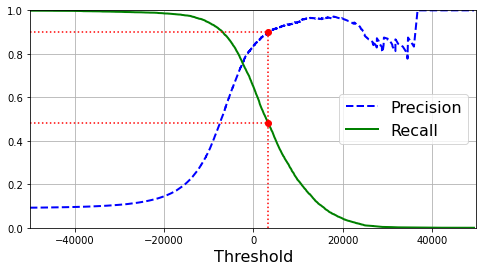

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # x축 데이터, y축 데이터, 파란색 점선, 라벨, 줄의 두께
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

    # legend: 그래프 데이터의 종류를 표시.
      # loc: 위치, fontsize: 글씨 크기
    plt.legend(loc="center right", fontsize=16)

    # xlabel: x축 이름 붙이기
    plt.xlabel("Threshold", fontsize=16)
    
    # grid(True)로 두면 그래프 안에 격자가 생기고 False로 두면 없어진다
    plt.grid(True)                            
    
    # 축의 구간 설정  
    plt.axis([-50000, 50000, 0, 1])            



# np.argmax: 최대값의 색인(index) 위치 찾기. 첫번째 인덱스를 반환한다.
# precision >= 0.90이상인 시점부터 recall의 최대값 지점
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]


threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


# (8, 4) 사이즈의 figure 생성
plt.figure(figsize=(8, 4))   

# 그래프 그리기
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
                                       
plt.show()

In [ ]:
(y_train_pred == (y_scores > 0)).all()

True

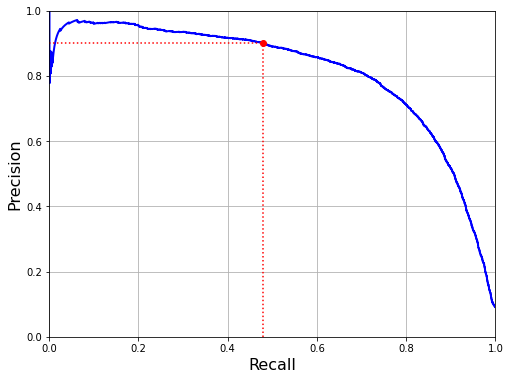

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    # x축 recall, y축 precision, 파란색 실선, 줄 두께 2
    plt.plot(recalls, precisions, "b-", linewidth=2)

    # x축 라벨에 Recall 적기
    plt.xlabel("Recall", fontsize=16)

    # y축 라벨에 precision 적기
    plt.ylabel("Precision", fontsize=16)

    # 두 축의 구간 정하기
    plt.axis([0, 1, 0, 1])

    # 그래프 안에 격자 넣기
    plt.grid(True)

# figure 선언
plt.figure(figsize=(8, 6))

# 만든 figure에 plot 넣기
plot_precision_vs_recall(precisions, recalls)

plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [ ]:
# np.argmax 메서드로 정밀도가 0.90이상이 되는 최소점의 임계값 지점을 찾는다.
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

threshold_90_precision

3370.0194991439557

In [ ]:
# 정밀도가 90% 이상인 임계값보다 높은 y_score
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
# 정밀도 확인
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
# 재현율 확인
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

#### ROC(Receive Operating Cjaracteristic) 곡선
수신기 조작 특성 곡선은 거짓 양성(거짓으로 잘못 분류된 음성 샘플) 비율에 대한 진짜 양성 비율이다.

In [ ]:
# roc_curve import
from sklearn.metrics import roc_curve

# fpr: 거짓 양성 비율. 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 tnr을 뺀 값이다.
# tpr: 진짜 양성 비율. 재현율의 다른 이름
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

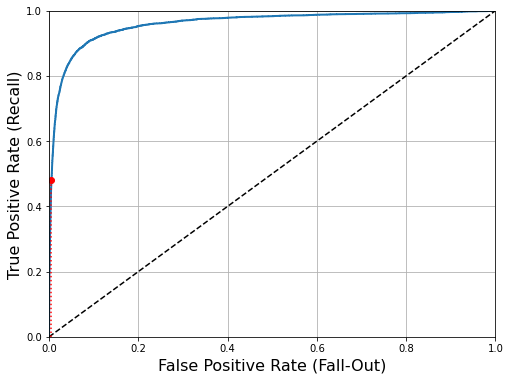

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                           

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")  
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")                                           
plt.show()

In [ ]:
# auc: 곡선 아래의 면적
  # 완벽한 분류기는 ROC의 AUC가 1이고 완전한 랜덤 분류기는 0.5이다.
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier의 n_estimator를 100, 난수 초기값을 42로
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)


y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

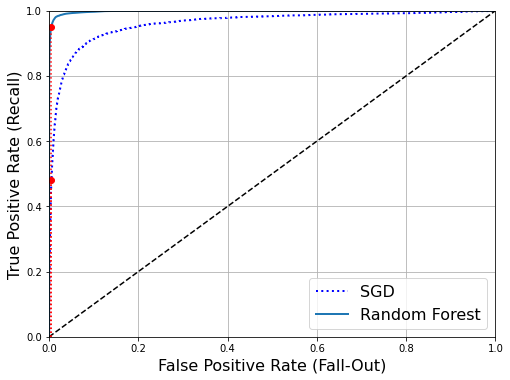

In [ ]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### 다중 분류

In [ ]:
# SVC: 서포트 벡터 머신 분류기
from sklearn.svm import SVC

# SVC 객체 생성
  # gamma: decision boundary를 조절하는 파라미터
svm_clf = SVC(gamma="auto", random_state=42)

# x_train, y_train 각각 1000번까지의 데이터를 적용
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
# decision_function 메서드를 호출해 샘플당 10개(클래스의 수)의 점수를 반환
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [ ]:
# 가장 높은 수치의 인덱스
np.argmax(some_digit_scores)

5

In [ ]:
# 클래스 출력
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

In [ ]:
# sklearn에서 OvO, OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용한다.
from sklearn.multiclass import OneVsRestClassifier

# SVC 기반으로 OvR 전략을 사용하는 다중 분류기 생성
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
# SGDClassifier로 다중 분류 수행
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
# SGDClassifier 분류기 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
# 입력 데이터의 스케일을 조정
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 적용
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### 에러 분석

In [ ]:
# cross_val_predict 함수를 호출해 예측을 만든다.
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

# 오차행렬 만들기
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    # figure 생성
    fig = plt.figure(figsize=(8,8))

    # figure 안에 넣을 subplot 생성
    ax = fig.add_subplot(111)

    # matshow 메서드를 이용해 인자로 받은 행렬을 이미지로 표현
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

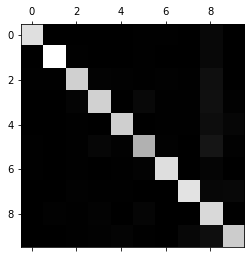

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

plt.show()

In [ ]:
# 오차행렬의 각 열을 더한다.
# keepdims: 행렬의 차원을 유지?
row_sums = conf_mx.sum(axis=1, keepdims=True)

# 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 계산
norm_conf_mx = conf_mx / row_sums

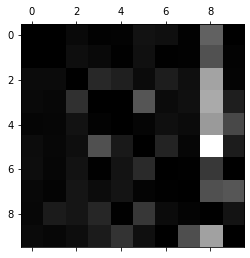

In [ ]:
# 주 대각선만 0으로 채운다.
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

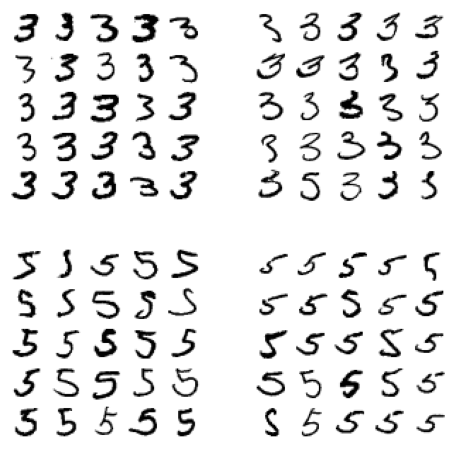

In [ ]:
# 3과 5의 샘플을 그려본다.
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### 다중 레이블 분류

In [ ]:
# KNeighborsClassifier import
from sklearn.neighbors import KNeighborsClassifier

# 숫자가 큰 값(7, 8, 9)인지 나타낸다
y_train_large = (y_train >= 7)

# 숫자가 홀수인지 나타낸다.
y_train_odd = (y_train % 2 == 1)

# 두 배열을 세로로 붙여 2차원 배열로
y_multilabel = np.c_[y_train_large, y_train_odd]

# KNeighborsClassifier 객체 생성
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
# 예측 생성
knn_clf.predict([some_digit]) # 출력 [[False, True]]: 숫자 5는 '크지 않고'(False), '홀수'이다.(True )

array([[False,  True]])

In [ ]:
# 교차 검증
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

# f1 score 
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

### 다중 출력 분류

In [ ]:
# randint 함수로 픽셀 강도에 잡음을 추가하기 위해 (len(x_train)x784) 크기의 noise 변수 정의
noise = np.random.randint(0, 100, (len(X_train), 784))

# 잡음 추가
X_train_mod = X_train + noise

# randint 함수로 픽셀 강도에 잡음을 추가하기 위해 (len(x_test)x784) 크기의 noise 변수 정의
noise = np.random.randint(0, 100, (len(X_test), 784))

# 잡음 추가
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

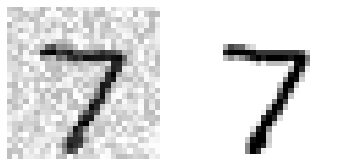

In [ ]:
some_index = 0
# 잡음을 추가한 이미지
plt.subplot(121); plot_digit(X_test_mod[some_index])

# 깨끗한 이미지
plt.subplot(122); plot_digit(y_test_mod[some_index])

plt.show()

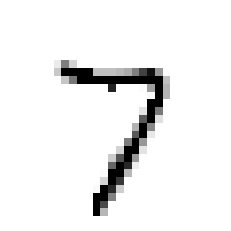

In [ ]:
# KNeighborClassifier 적용
knn_clf.fit(X_train_mod, y_train_mod)

# 예측
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)


# 4장. 모델 훈련

### 선형 회귀

In [ ]:
import numpy as np

# 0~1의 균일 분포 표준 정규 분포 난수를 matrix array(m, n) 생성
X = 2 * np.random.rand(100, 1)

# 평균 0, 표준편차 1의 가우시안 표준 정규 분포 난수를 matrix array(m, n) 생성
y = 4 + 3 * X + np.random.randn(100, 1)

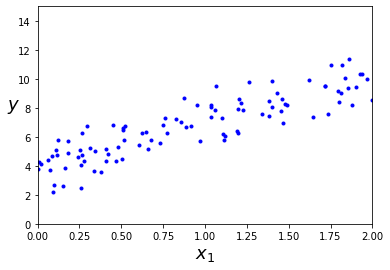

In [ ]:
import matplotlib.pyplot as plt

# plot 생성(x축에 X, y축에 y, 파란 점)
plt.plot(X, y, "b.")

# x축 라벨 붙이기
plt.xlabel("$x_1$", fontsize=18)

# y축 라벨 붙이기
plt.ylabel("$y$", rotation=0, fontsize=18)

# x축과 y축의 범위 지정
plt.axis([0, 2, 0, 15])
plt.show()

In [ ]:
# np.c_: 두 데이터를 길게 붙여 두 열로 만들어 행렬을 만든다.
# np.ones: 행렬의 구성 원소가 전부 1인 행렬.
# X_b 변수에 (100, 1)인 행렬의 원소가 전부 1인 행렬과 X를 이어붙여 저장하셈
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가합니다.

# np.linalg: 넘파이 선형대수 모듈
  # np.linalg.inv: 역행렬 계산
  # T: 행렬를 Transpose 형태를 회전시켜 변형한다.
  # dot: 행렬 곱셈
# X_b를 transpose한 행렬과 기존의 X_b를 행렬 곱셈한 결과의 역행렬을 계산, 
# 위 결과 행렬과 X_b.T 행렬, y 행렬을 곱한다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [ ]:
# 정규 방정식으로 계산한 값을 확인
theta_best

array([[3.95853641],
       [3.07768373]])

In [ ]:
# [[0], [2]]로 이루어진 행렬
X_new = np.array([[0], [2]])

# 2행 1열이 1로 이루어진 행렬과 X_new를 이어 붙임
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.

# 예측 생성
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.95853641],
       [10.11390388]])

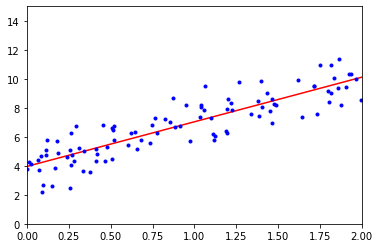

In [ ]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [ ]:
# sklearn에서 제공하는 선형 회귀 모델 import
from sklearn.linear_model import LinearRegression

# LinearRegression() 객체 생성
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# intercept: 절편
# coef: 기울기
lin_reg.intercept_, lin_reg.coef_

(array([3.95853641]), array([[3.07768373]]))

In [ ]:
lin_reg.predict(X_new)

array([[ 3.95853641],
       [10.11390388]])

In [ ]:
# LinearRegression 클래스는 scipy.linalg.lstsq() 함수를 기반으로 하는데, 이 함수를 직접 호출
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.95853641],
       [3.07768373]])

In [ ]:
# np.linalg.pinv() 메서드로 유사 역행렬을 구한다
np.linalg.pinv(X_b).dot(y)

array([[3.95853641],
       [3.07768373]])

#### 경사 하강법

In [ ]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 랜덤 초기화

# n_iterations에 저장된 수만큼 반복
for iteration in range(n_iterations):

    # 기울기 구하기
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [ ]:
theta

array([[3.95853641],
       [3.07768373]])

In [ ]:
X_new_b.dot(theta)

array([[ 3.95853641],
       [10.11390388]])

In [ ]:
# 리스트 생성
theta_path_bgd = []

# 여러 가지 학습률에 대한 경사 하강법
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

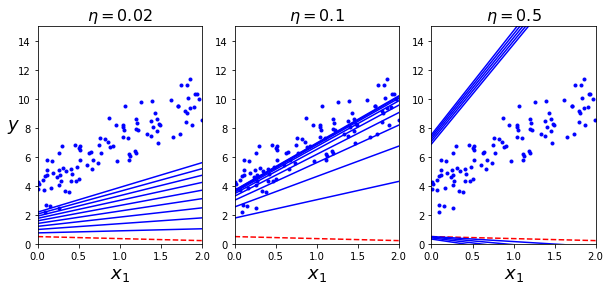

In [ ]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

#### 확률적 경사 하강법

In [ ]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

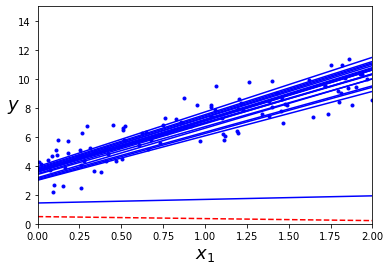

In [ ]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

# 반복에서 학습률을 결정하는 함수
def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

# 반복 한번 할 때 마다:
for epoch in range(n_epochs):

    # range(m)을 돌 때마다
    for i in range(m):
        # 만약 epoch가 0이고 i가 20보다 작으면
        if epoch == 0 and i < 20:             
            # y_predict는 X_new_b와 theta를 곱한 값       
            y_predict = X_new_b.dot(theta)
            # i가 0보다 크면 파란 실선, 아니면 빨간 점선          
            style = "b-" if i > 0 else "r--"
            # x축은 X_new, y축은 y_predict         
            plt.plot(X_new, y_predict, style)
        # random_index에 무작위 수를 넣음        
        random_index = np.random.randint(m)
        # xi에 X_b의 random_index부터 random_index+1 까지의 인덱스에 해당하는 데이터를 저장
        xi = X_b[random_index:random_index+1]
        # yi에 y의 random_index부터 random_index+1 까지의 인덱스에 해당하는 데이터를 저장
        yi = y[random_index:random_index+1]
        # 기울기
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        # 학습률
        eta = learning_schedule(epoch * m + i)
        # theta값 계산
        theta = theta - eta * gradients
        # 리스트에 theta값 저장
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                                                            
plt.show()   

In [ ]:
# SGDRegressor import
from sklearn.linear_model import SGDRegressor

# SGDRegressor 객체 생성. 반복수 1000번, 실행 조건(tol=1e-3), 규제는 사용하지 않음(penalty-None), 학습률(eta=0.1), 난수 초기값)
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [ ]:
# intercept: 절편
# coef: 기울기
sgd_reg.intercept_, sgd_reg.coef_

(array([3.94928669]), array([3.07192547]))

#### 미니배치 경사 하강법

In [ ]:
theta_path_mgd = []

# 반복수
n_iterations = 50
# batch 크기
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

# 학습률 파라미터
t0, t1 = 200, 1000

# 반복에서 학습률을 결정하는 함수
def learning_schedule(t):
    return t0 / (t + t1)

t = 0

# n_iterations 만큼 반복
for epoch in range(n_iterations):
    # np.random.permutation 메서드는 array를 복사해서 셔플한다.
      # 비슷한 기능인 shuffle은 셔플할 경우 원본 array 자체가 변한다.
    shuffled_indices = np.random.permutation(m)

    # X_b shuffled 변수에 X_b의 셔플한 인덱스로 저장한다.
    X_b_shuffled = X_b[shuffled_indices]

    # y_shuffeld에도 같은 방식으로 저장
    y_shuffled = y[shuffled_indices]

    # 0부터 m까지, minibatch_size만큼의 간격으로 반복
    for i in range(0, m, minibatch_size):
        t += 1
        # i부터 i+minibatch_size까지의 인덱스에 해당하는 X_b_shuffled의 데이터를 xi에 저장
        xi = X_b_shuffled[i:i+minibatch_size]

        # 위와 같은 작업을 y_shuffled에 해주고 해당 데이터를 yi에 저장
        yi = y_shuffled[i:i+minibatch_size]

        # 기울기 계산
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)

        # 학습률
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [ ]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

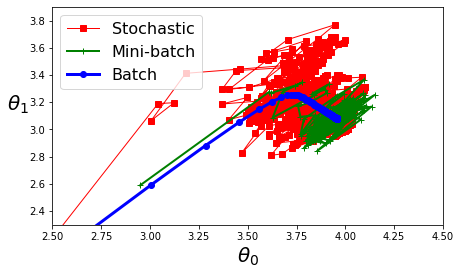

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

### 다항 회귀

In [ ]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [ ]:
# 2차 방정식으로 비선형 데이터 생성
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

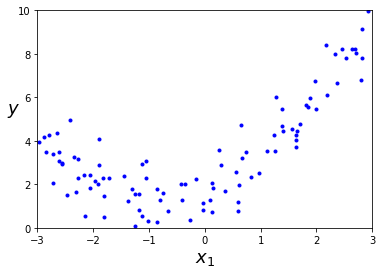

In [ ]:
# 파란색 점선으로 그래프 그리기
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [ ]:
# PolynomialFeature로 현재 데이터를 다항식 형태로 변경한다.(각 특성에 제곱 혹은 그 이상을 추가)
from sklearn.preprocessing import PolynomialFeatures

# PolynomialFeatures 객체 생성(degree(차수)=2, includs_bias를 True로 할 경우 0차항(1)도 함께 만든다.)
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [ ]:
# X_poly는 원래 특성 X와 이 특성의 제곱을 포함한다.
X_poly[0]

array([-0.75275929,  0.56664654])

In [ ]:
# X_poly에 선형 회귀를 적용해보자
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

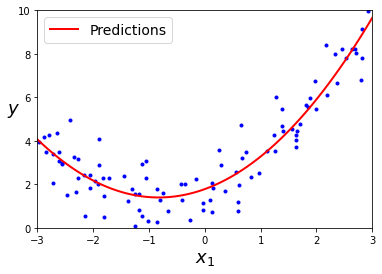

In [ ]:
# np.linspace: 
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()